# Compute  PCA : Method 1 for Bruzual Charlot

- use PCA scikit learn from scikit learn

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab
- creation date : 2023/01/08
- last update : 2023/01/08

In [1]:
# Import some generally useful packages

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

from matplotlib.backends.backend_pdf import PdfPages

%matplotlib inline
import pandas as pd
from itertools import cycle, islice

from astroML.utils.decorators import pickle_results


In [2]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)


In [3]:
from sklearn.decomposition import NMF, FastICA, PCA

In [4]:
from astropy.io import fits

## Start

In [1]:
cwd=os.path.abspath("")
main_dir = cwd
print(f"notebook current executing path : {cwd}")

NameError: name 'os' is not defined

## Read file

In [5]:
filename = 'datatools/pca_BruzualCharlot_data.fits'
hdu = fits.open(filename)
data_in=hdu[0].data
hdr_in = hdu[0].header

In [6]:
data_in

array([[0.00000000e+00, 9.10000000e+01, 9.40000000e+01, ...,
        9.95000000e+03, 9.97000000e+03, 9.99000000e+03],
       [0.00000000e+00, 4.97839069e-07, 5.52382959e-07, ...,
        7.06085364e-05, 7.06330908e-05, 7.05906948e-05],
       [0.00000000e+00, 1.19574179e-06, 1.27758431e-06, ...,
        4.46025945e-05, 4.46908296e-05, 4.46647757e-05],
       ...,
       [7.36000000e+02, 2.14675694e-06, 2.50389986e-06, ...,
        2.12861759e-05, 2.12363909e-05, 2.11664152e-05],
       [7.37000000e+02, 8.31448778e-07, 9.57832321e-07, ...,
        7.00733914e-05, 6.99426115e-05, 7.00519814e-05],
       [7.38000000e+02, 7.21010321e-08, 8.01113405e-08, ...,
        1.50517900e-04, 1.50795383e-04, 1.50744720e-04]])

In [7]:
NSED = data_in.shape[0]-3
NWL = data_in.shape[1]-1

In [8]:
wavelengths = data_in[0,1:] 
flambdas_average = data_in[1,1:] 
flambdas_std = data_in[2,1:] 
spec = data_in[3:,1:] 
all_numbers = data_in[3:,0] 

In [9]:
#flux = dfluxnorm*flambdas_std +  flambdas_average

/var/folders/rk/cnrspsj13_3cgmh8p4m_mxww0000gp/T/ipykernel_54435/1659706449.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:.0f}'.format(x) for x in current_values])


Text(0.5, 1.0, 'Flux average')

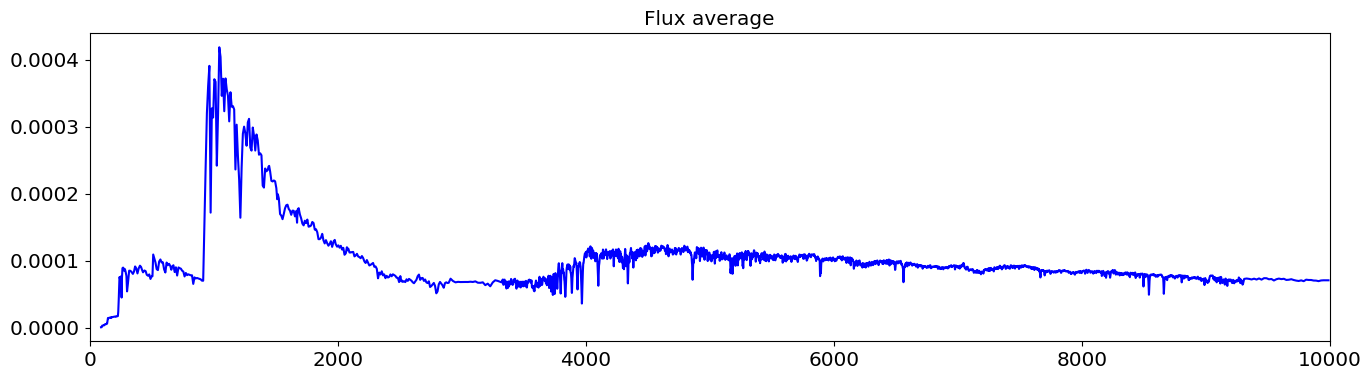

In [10]:
plt.figure(figsize=(16,4))
plt.plot(wavelengths,flambdas_average,'b-')
plt.xlim(0.,10000.)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:.0f}'.format(x) for x in current_values])
plt.title("Flux average")

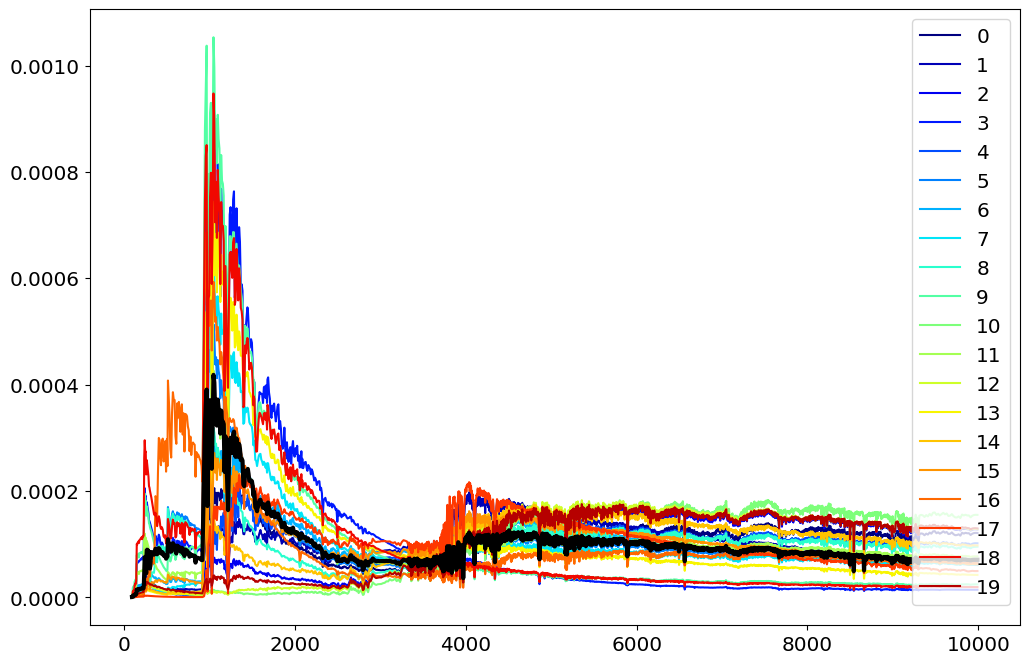

In [11]:
# wavelength bin colors
NTOPLOT=20
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NTOPLOT)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NTOPLOT), alpha=1)


fig = plt.figure(figsize=(12, 8))

for idx in np.arange(20):
    plt.plot(wavelengths,spec[idx,:],color=all_colors[idx],label=str(idx))

plt.legend()
spec_mean = spec.mean(0)
plt.plot(wavelengths,spec_mean,"k-",lw=3)
#plt.ylim(0,50.)

## Principal Component Analysis


https://www.astroml.org/astroML-notebooks/chapter7/astroml_chapter7_Dimensionality_Reduction.html


#### Derivation of principal component analyses

Set of data $X$: $N$ observations by $K$ measurements

Center data by subtracting the mean 

The covariance is

$$ C_X=\frac{1}{N-1}X^TX,$$

$N-1$ as the sample covariance matrix.

We want a projection, $R$,  aligned with the directions of maximal variance ($Y= X R$) with covariance 

$$C_{Y} = R^T X^T X R = R^T C_X R$$

Derive  principal component by maximizing its variance (using Lagrange multipliers and constraint)

$$\phi(r_1,\lambda_1) = r_1^TC_X r_1 - \lambda_1(r_1^Tr_1-1)$$

derivative of $\phi(r_1,\lambda)$ with respect to $r_1$ set to 0

$$C_Xr_1 - \lambda_1 r_1 = 0$$

$\lambda_1$ is the root of the equation $\det(C_X -
\lambda_1 {\bf I})=0$ and the largest eigenvalue

$$\lambda_1 =  r_1^T C_X r_1$$

Other  principal components  derived by
applying additional constraint that components are uncorrelated (e.g., $r^T_2 C_X r_1 = 0$).

#### Singular value decomposition (SVD)
Common approach is eigenvalue decomposition of the covariance or correlation matrix,
or singular value decomposition (SVD) of the data matrix

$$U \Sigma V^T = \frac{1}{\sqrt{N - 1}} X$$

columns of $U$ are  _left-singular vectors_

columns of $V$ are the _right-singular vectors_

The columns of $U$ and $V$ form orthonormal bases ($U^TU = V^TV = I$)

Covariance matrix is

$$
  C_X = \left[\frac{1}{\sqrt{N - 1}}X\right]^T \left[\frac{1}{\sqrt{N - 1}}X\right]\nonumber\\
      = V \Sigma U^T U \Sigma V^T\nonumber\\
      = V \Sigma^2 V^T.
$$

right singular vectors $V$ are the principal components so principal from the SVD of $X$ dont need $C_X$.

In [12]:
#https://www.astroml.org/astroML-notebooks/chapter7/astroml_chapter7_Dimensionality_Reduction.html
#https://stackoverflow.com/questions/31909945/obtain-eigen-values-and-vectors-from-sklearn-pca
"""
X_recons: ndarray, shape = (n_samples, n_features)       data with masked regions reconstructed
mu: ndarray, shape = (n_features,)                       mean of data
evecs: ndarray, shape = (min(n_samples, n_features), n_features) eigenvectors of the reconstructed data
evals: ndarray, size = min(n_samples, n_features)        eigenvalues of the reconstructed data
norms: ndarray, size = n_samples                         normalization of each input
coeffs: ndarray, size = (n_samples, n_ev)                coefficients used to reconstruct X
"""

'\nX_recons: ndarray, shape = (n_samples, n_features)       data with masked regions reconstructed\nmu: ndarray, shape = (n_features,)                       mean of data\nevecs: ndarray, shape = (min(n_samples, n_features), n_features) eigenvectors of the reconstructed data\nevals: ndarray, size = min(n_samples, n_features)        eigenvalues of the reconstructed data\nnorms: ndarray, size = n_samples                         normalization of each input\ncoeffs: ndarray, size = (n_samples, n_ev)                coefficients used to reconstruct X\n'

### Compute PCA decomposition

- set n_components

In [13]:
Ncomp=10
pca = PCA(n_components=Ncomp)
pca.fit(spec)
# coefficients of the data in the new eigen verctor frame
#comp = pca.transform(spec)
pca_coeffs = pca.transform(spec)
#explained_variance_ is eigen value
#evals = pca.explained_variance_ratio_
evals = pca.explained_variance_  # eigen  values
evals_cs = evals.cumsum()
evals_cs /= evals_cs[-1]

In [14]:
pca_coeffs.shape

(550, 10)

#### Eigen values

In [15]:
evals

array([1.50747493e-05, 1.61699178e-06, 6.41351285e-07, 2.06146996e-07,
       7.67167128e-08, 3.30620596e-08, 1.59623539e-08, 6.45871958e-09,
       4.69099663e-09, 3.24458766e-09])

#### Normalized Cumulated Eigen Values

In [16]:
evals_cs

array([0.85267434, 0.94413639, 0.9804132 , 0.99207351, 0.99641284,
       0.99828293, 0.99918581, 0.99955114, 0.99981648, 1.        ])

#### Don't know what singular_values_

In [17]:
pca.singular_values_.shape

(10,)

In [18]:
pca.singular_values_

array([0.09097273, 0.02979477, 0.01876438, 0.01063836, 0.0064898 ,
       0.00426041, 0.00296029, 0.00188304, 0.00160479, 0.00133465])

#### Eigen-Vector

respect to the old base

In [19]:
# Eigen vectors
evecs = pca.components_

#### Compute Eigen-Value by the formula

- eigen value $\lambda_i$ for the eigen vector $r_i$ (coordinate wrt original base):
$$
\lambda_i =  r_i^T C_X r_i
$$

where $ C_X=\frac{1}{N-1}X^TX,$

In [20]:
import copy
X = copy.deepcopy(spec)
n_samples = X.shape[0]
X -= np.mean(X, axis=0)
cov_matrix = np.dot(X.T, X) / n_samples
for idx,eigenvector in enumerate(pca.components_):
    print(f"eigen value {idx} : ",np.dot(eigenvector.T, np.dot(cov_matrix, eigenvector)))

eigen value 0 :  1.5047340681032488e-05
eigen value 1 :  1.6140517991809814e-06
eigen value 2 :  6.401851922302372e-07
eigen value 3 :  2.0577218285708646e-07
eigen value 4 :  7.657722784310617e-08
eigen value 5 :  3.3001946760167425e-08
eigen value 6 :  1.5933331468502894e-08
eigen value 7 :  6.446976452454376e-09
eigen value 8 :  4.682467544806e-09
eigen value 9 :  3.238688414219924e-09


In [21]:
evecs.shape

(10, 6361)

coeff [-2.25712044e-03  6.57533259e-04 -9.50868170e-04 -4.83666987e-04
  3.52339363e-04  1.62112917e-05  1.41391652e-04 -8.84901065e-05
 -1.80317333e-05  1.37565070e-05]
pca_coeffs =  [-2.25712044e-03  6.57533259e-04 -9.50868170e-04 -4.83666987e-04
  3.52339363e-04  1.62112917e-05  1.41391652e-04 -8.84901065e-05
 -1.80317333e-05  1.37565070e-05]


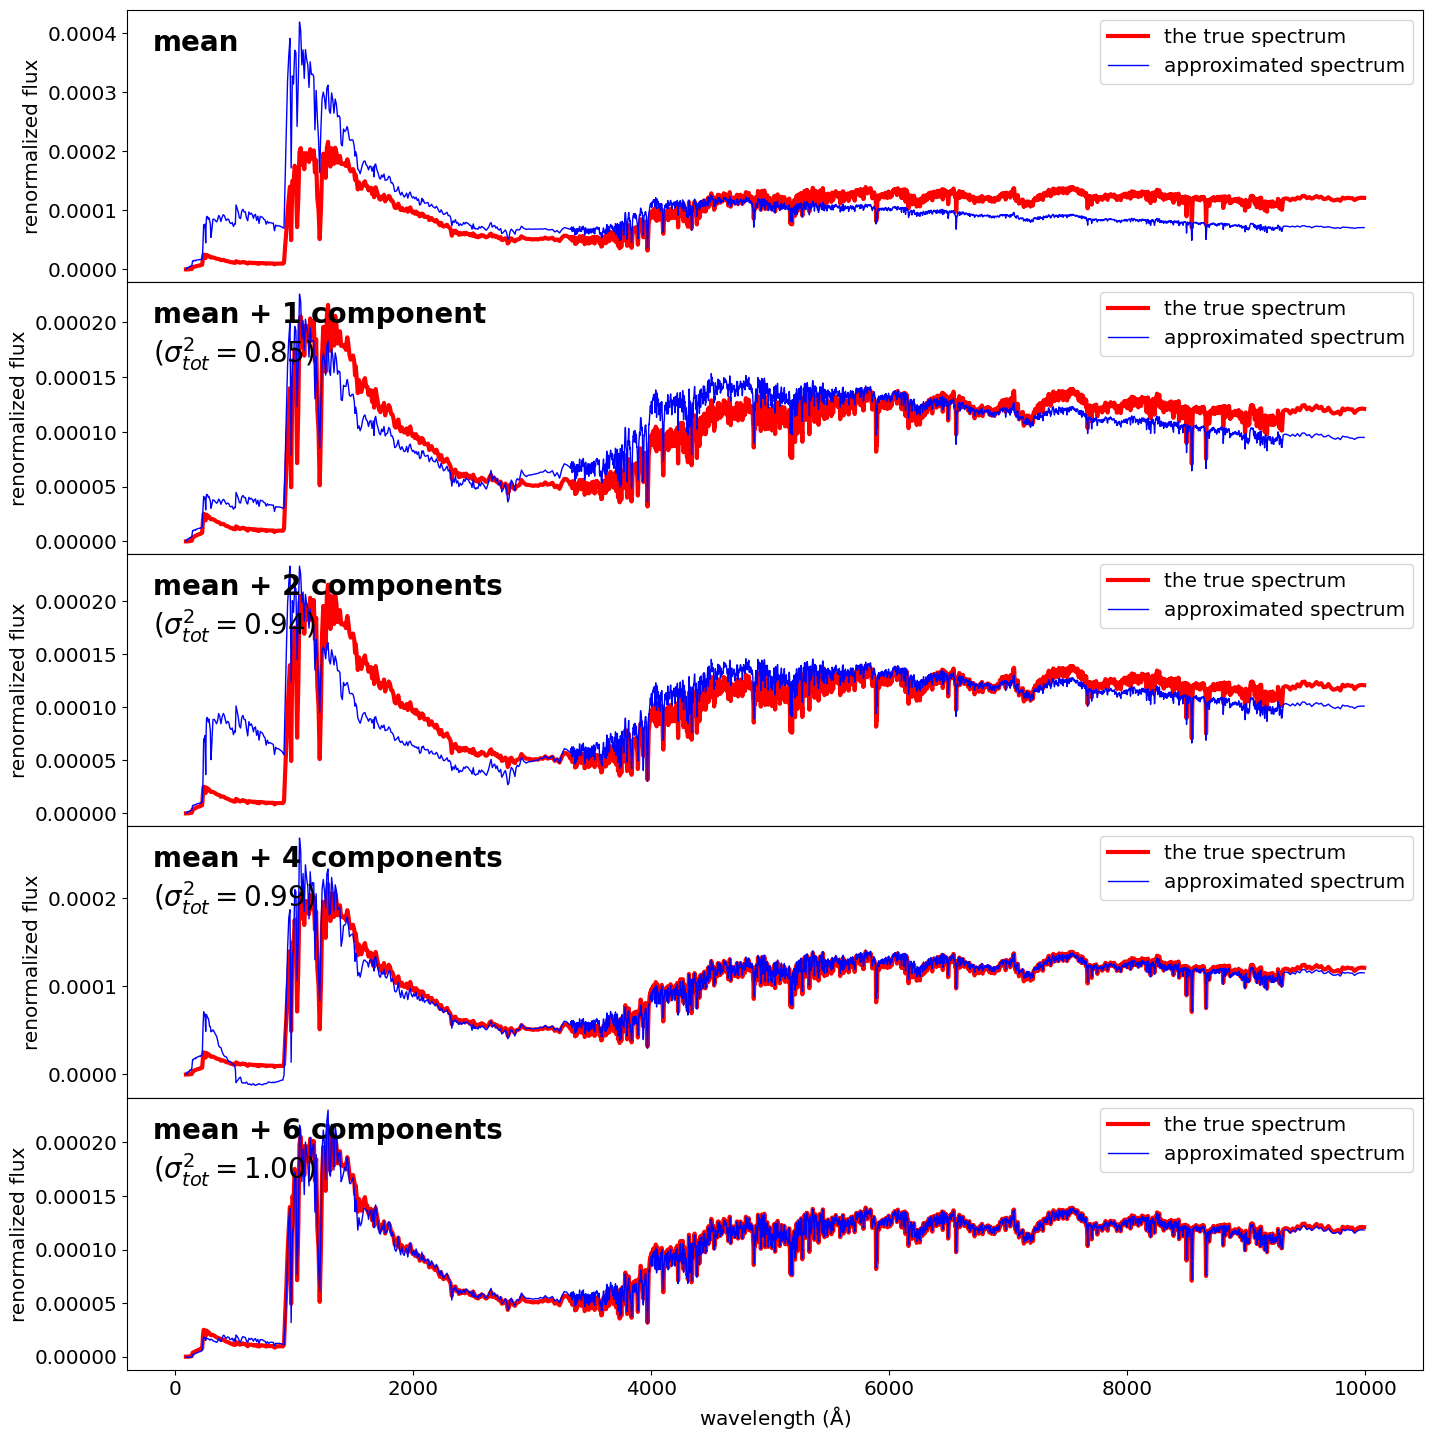

In [22]:
#------------------------------------------------------------
# Find the coefficients of a particular spectrum
idx=0
the_spec = spec[idx,:]
# computation of the coefficients 
coeff = np.dot(evecs, the_spec - spec_mean)
print("coeff",coeff)
# similar to comp = pca.transform(spec)
print("pca_coeffs = ",pca_coeffs[idx,:])

#------------------------------------------------------------
# Plot the sequence of reconstructions
fig = plt.figure(figsize=(16, 16))
fig.subplots_adjust(hspace=0, top=0.95, bottom=0.1, left=0.12, right=0.93)

for i, n in enumerate([0, 1 , 2, 4, 6 ]):
    ax = fig.add_subplot(511 + i)
    ax.plot(wavelengths, the_spec, '-', color='red',lw=3,label="the true spectrum")
    ax.plot(wavelengths, spec_mean + np.dot(coeff[:n], evecs[:n]), '-b',lw=1,label="approximated spectrum")

    if i < 3:
        ax.xaxis.set_major_formatter(plt.NullFormatter())

    #ax.set_ylim(-2, 21)
    ax.set_ylabel('renormalized flux')

    if n == 0:
        text = "mean"
    elif n == 1:
        text = "mean + 1 component\n"
        text += r"$(\sigma^2_{tot} = %.2f)$" % evals_cs[n - 1]
    else:
        text = "mean + %i components\n" % n
        text += r"$(\sigma^2_{tot} = %.2f)$" % evals_cs[n - 1]

    ax.text(0.02, 0.93, text, ha='left', va='top', transform=ax.transAxes,fontsize=20,fontweight="bold")
    ax.legend()

fig.axes[-1].set_xlabel(r'${\rm wavelength\ (\AA)}$')
plt.show()

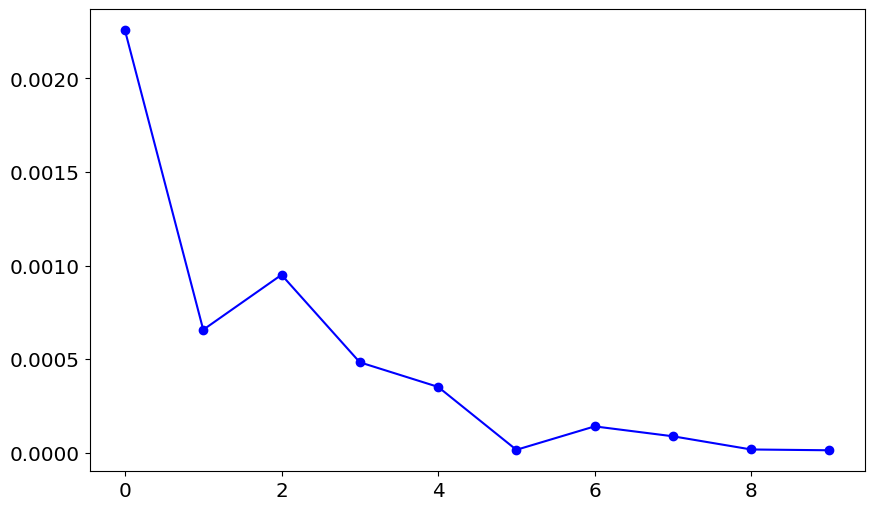

In [23]:
#plt.step(np.arange(len(coeff)),coeff)
plt.plot(range(len(coeff)),np.abs(coeff),'ob-')

### Eigenvalues

The top panel shows the decrease in eigenvalue as a function of the number of eigenvectors, with a break in the distribution at ten eigenvectors. The lower panel shows the cumulative sum of eigenvalues normalized to unity. 

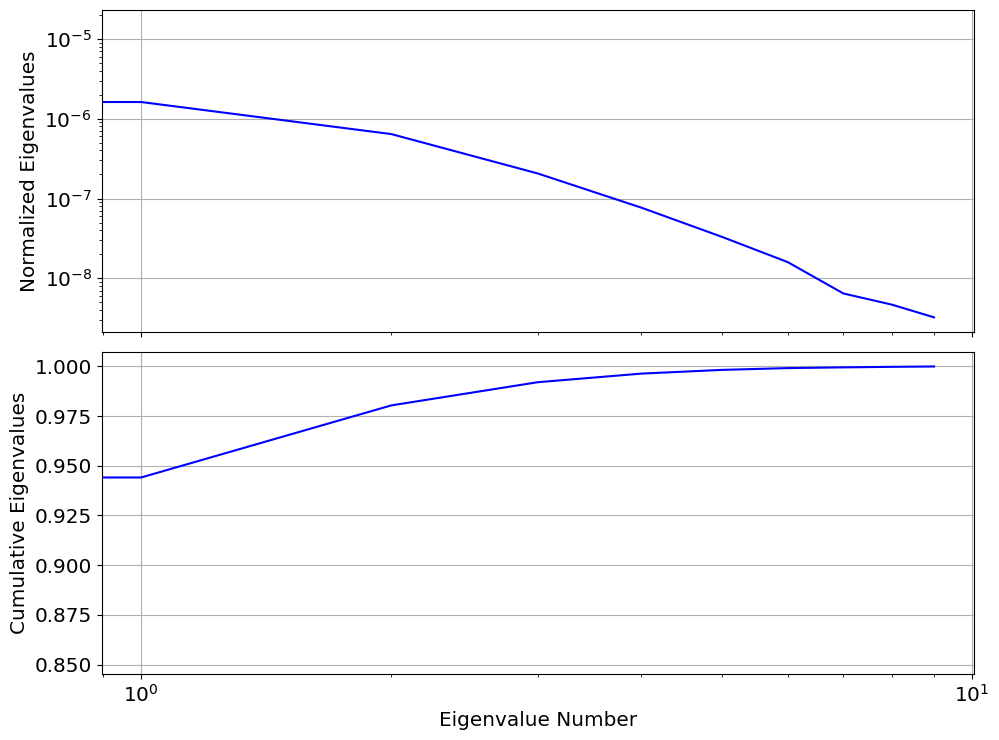

In [24]:
fig = plt.figure(figsize=(10, 7.5))
fig.subplots_adjust(hspace=0.05, bottom=0.12)

ax = fig.add_subplot(211, xscale='log', yscale='log')
ax.grid()
ax.plot(evals, c='b')
ax.set_ylabel('Normalized Eigenvalues')
ax.xaxis.set_major_formatter(plt.NullFormatter())
#ax.set_ylim(5E-4, 100)

ax = fig.add_subplot(212, xscale='log')
ax.grid()
ax.semilogx(evals_cs, color='b')
ax.set_xlabel('Eigenvalue Number')
ax.set_ylabel('Cumulative Eigenvalues')
#ax.set_ylim(0.65, 1.00)
plt.tight_layout()
plt.show()


# Compute for all coefficients

### PCA Reconstruction of a spectrum

Reconstruction of spectrum, ${x}(k)$, from the
eigenvectors, ${e}_i(k)$ 

$$  {x}_i(k) = {\mu}(k) + \sum_j^R \theta_{ij} {e}_j(k),$$

Truncating this expansion (i.e., $r<R$)

$$
{x}_i(k) = {\mu}(k) + \sum_i^{r<R} \theta_i {e}_i(k),
$$

- eigenvectors ordered by their associated eigenvalues 
- eigenvalues reflect variance  within each eigenvector (sum of the eigenvalues is total variance of the system).
- project a each spectrum onto these first few eigenspectra is a compression of the data 

This is the sense in which PCA gives for dimensionality reduction.

In [25]:
evecs = pca.components_

In [26]:
#------------------------------------------------------------
# Find the coefficients of a particular spectrum
all_coeff = []
for idx in range(NSED):
    the_spec = spec[idx,:]
    coeff = np.dot(evecs, the_spec - spec_mean)
    all_coeff.append(coeff)
all_coeff=np.vstack(all_coeff)

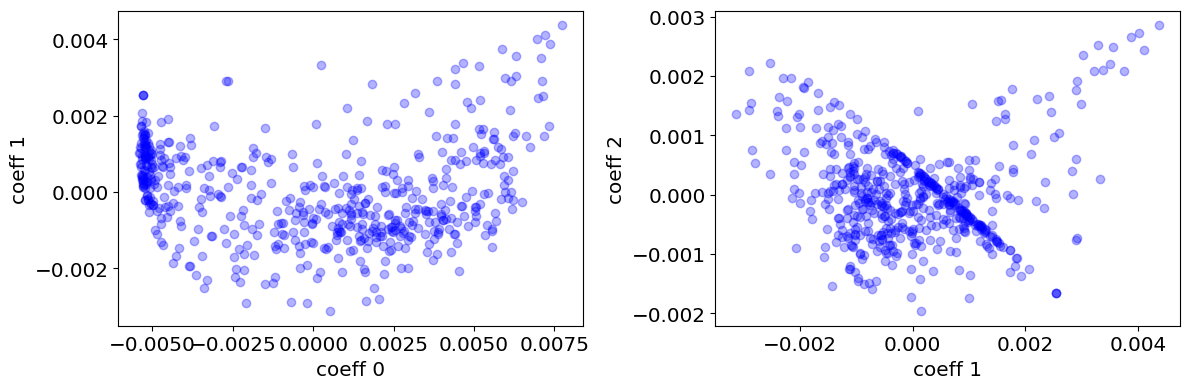

In [27]:
fig=plt.figure(figsize=(12,4))
ax=fig.add_subplot(1,2,1)
ax.scatter(all_coeff[:,0],all_coeff[:,1],c='b',alpha=0.3)
ax.set_xlabel("coeff 0")
ax.set_ylabel("coeff 1")  
ax=fig.add_subplot(1,2,2)
ax.scatter(all_coeff[:,1],all_coeff[:,2],c='b',alpha=0.3)
ax.set_xlabel("coeff 1")
ax.set_ylabel("coeff 2")
plt.tight_layout()

In [28]:
all_coeff

array([[-2.25712044e-03,  6.57533259e-04, -9.50868170e-04, ...,
        -8.84901065e-05, -1.80317333e-05,  1.37565070e-05],
       [-2.30109429e-03, -1.49288699e-03,  1.14485205e-03, ...,
         2.32379730e-05,  1.11383018e-05, -5.88786600e-05],
       [-4.27954488e-03,  8.86200963e-04, -5.35232078e-04, ...,
        -2.71682535e-05,  6.99615660e-05, -3.18374797e-05],
       ...,
       [ 4.29215039e-03, -6.79003850e-04, -3.10725242e-04, ...,
        -9.47919752e-05, -1.18315510e-05,  1.63367586e-05],
       [-2.16337005e-03, -8.69601974e-04,  7.72706723e-04, ...,
         3.83708186e-05,  5.03337687e-05, -8.33788495e-05],
       [-5.19235912e-03,  1.22245231e-03, -5.50897014e-04, ...,
         2.49129363e-06, -6.50061238e-05,  2.54474445e-05]])

In [29]:
pca_coeffs 

array([[-2.25712044e-03,  6.57533259e-04, -9.50868170e-04, ...,
        -8.84901065e-05, -1.80317333e-05,  1.37565070e-05],
       [-2.30109429e-03, -1.49288699e-03,  1.14485205e-03, ...,
         2.32379730e-05,  1.11383018e-05, -5.88786600e-05],
       [-4.27954488e-03,  8.86200963e-04, -5.35232078e-04, ...,
        -2.71682535e-05,  6.99615660e-05, -3.18374797e-05],
       ...,
       [ 4.29215039e-03, -6.79003850e-04, -3.10725242e-04, ...,
        -9.47919752e-05, -1.18315510e-05,  1.63367586e-05],
       [-2.16337005e-03, -8.69601974e-04,  7.72706723e-04, ...,
         3.83708186e-05,  5.03337687e-05, -8.33788495e-05],
       [-5.19235912e-03,  1.22245231e-03, -5.50897014e-04, ...,
         2.49129363e-06, -6.50061238e-05,  2.54474445e-05]])

## Save a coefficient in a fits file

In [30]:
filename_out = "pcamethod1_BruzualCharlot_eigenvectorandcoeff.fits"
hdr = fits.Header()
hdr["COMMENT"] = "PCA method 1 spectra coefficients"
hdr2 = fits.Header()
hdr2["COMMENT"] = "PCA method 1 Eigen Vectors"

In [31]:
primary_hdu = fits.PrimaryHDU(data_in,hdr_in)
image_hdu = fits.ImageHDU(all_coeff,hdr)
image_hdu2 = fits.ImageHDU(pca.components_,hdr2)

In [32]:
hdul = fits.HDUList([primary_hdu, image_hdu, image_hdu2])

In [33]:
hdul.writeto(filename_out,overwrite=True)